# Simulating the Role Passport on cadCAD

## Part 1: Pre-requisites

In [1]:
from dataclasses import dataclass
from functools import reduce
from typing import NamedTuple, TypedDict, Callable
from cadCAD_tools.types import *
from cadCAD_tools.execution import easy_run
from random import random, normalvariate, seed
from copy import deepcopy, copy

## Part 2: Module Logic

### Types & Classes

In [2]:
AttestationUUID = str
AttestationWeight = float
Days = int


class AttestationProbabilityArgs(NamedTuple):
    attest_probability: float
    invoke_probability: float
    issuance_mean_expiry_in_days: Days
    issuance_std_expiry_in_days: Days


@dataclass
class Attestation():
    """
    TODO: add docstring
    """
    attestation_uuid: AttestationUUID
    result: bool  # Between 0.0 and 1.0
    issuance: Days
    expiry: Days


@dataclass
class PassportDemoAgent():
    """
    TODO: add docstring
    """
    attestations: dict[AttestationUUID, Attestation]
    # attestation_history: list[Attestation]

    def valid_attestations(self, reference_time) -> list[Attestation]:
        """
        TODO: add docstring
        """
        return [a
                for a in self.attestations.values()
                if a.expiry > reference_time
                and a.issuance <= reference_time]

    def sucessful_attestations(self, reference_time) -> list[Attestation]:
        """
        TODO: add docstring
        """
        return [a
                for a in self.valid_attestations(reference_time)
                if a.result == True]



@dataclass
class RoleCertificator():
    """
    TODO: add docstring
    """
    attestation_uuid: AttestationUUID
    issuance_validity: Days

    conditional_qualifiers: dict[AttestationUUID, AttestationWeight]
    auto_qualifers: set[AttestationUUID]
    disqualifiers: set[AttestationUUID]

    qualifier_aggregator: Callable[[dict], float]
    conditional_threshold: float

    def generate_attestation(self, result: bool, time: Days) -> Attestation:
        """
        TODO: add docstring
        """
        return Attestation(self.attestation_uuid,
                           result,
                           time,
                           time + self.issuance_validity)

    def agent_certification_result(self,
                                   agent: PassportDemoAgent,
                                   time: Days) -> bool:
        """
        TODO: add docstring
        """
        agent_sucessful_attestations = set(a.attestation_uuid
                                           for a in agent.valid_attestations(time)
                                           if a.result == True)

        if len(agent_sucessful_attestations & self.disqualifiers) > 0:
            return False
        elif len(agent_sucessful_attestations & self.auto_qualifers) > 0:
            return True
        else:
            conditional_attestations = set(self.conditional_qualifiers.keys())
            agent_relevant_attestations = agent_sucessful_attestations & conditional_attestations

            agent_conditional_values = {a: self.conditional_qualifiers[a]
                                        for a
                                        in agent_relevant_attestations}
            agent_conditional_value = self.qualifier_aggregator(
                agent_conditional_values)
            if agent_conditional_value >= self.conditional_threshold:
                return True
            else:
                return False

    def attestate_agent(self, agent: PassportDemoAgent, time: Days):
        return self.generate_attestation(self.agent_certification_result(agent, time), time)


## Part 3: cadCAD Simulation

### cadCAD Logic & Structure

In [3]:
class RolePassportDemoModelState(TypedDict):
    days_passed: Days
    agents: list[PassportDemoAgent]

    # Metrics
    n_valid_attestations: int
    n_valid_true_attestations: int
    n_expired_attestations: int


class RolePassportDemoModelParams(TypedDict):
    days_per_timestep: Days
    attestation_providers: dict[AttestationUUID, AttestationProbabilityArgs]
    role_certifactors: list[RoleCertificator]

def p_time(params: RolePassportDemoModelParams, _2, _3, _4):
    return {'days_delta': params['days_per_timestep']}


def s_days_passed(params: RolePassportDemoModelParams,
                  _2,
                  _3,
                  state: RolePassportDemoModelState,
                  signal):
    return ('days_passed', state['days_passed'] + signal['days_delta'])


def s_agents_attestations(params: RolePassportDemoModelParams,
                          _2,
                          _3,
                          state: RolePassportDemoModelState,
                          signal):
    seed()
    agents_copy = deepcopy(state['agents'])

    time = state['days_passed']
    for agent in agents_copy:
        for provider, provider_prob in params['attestation_providers'].items():
            if provider not in agent.sucessful_attestations(time):
                if random() < provider_prob.invoke_probability:
                    result = random() < provider_prob.attest_probability
                    expiry_delta = max(normalvariate(mu=provider_prob.issuance_mean_expiry_in_days,
                                                     sigma=provider_prob.issuance_std_expiry_in_days), 1)
                    expiry_time = time + expiry_delta
                    new_att = Attestation(provider,
                                          result,
                                          time,
                                          expiry_time)
                    agent.attestations[provider] = new_att

    return ('agents', agents_copy)


def s_agents_roles(params: RolePassportDemoModelParams,
                   _2,
                   _3,
                   state: RolePassportDemoModelState,
                   signal):
    time = state['days_passed']
    agents_copy = deepcopy(state['agents'])
    certificators = params['role_certifactors']
    for agent in agents_copy:
        for certificator in certificators:
            if certificator.attestation_uuid not in agent.sucessful_attestations(time):
                agent.attestations[certificator.attestation_uuid] = certificator.attestate_agent(agent, time)
            else:
                pass
    return ('agents', agents_copy)


def s_n_valid_attestations(_1, _2, _3, s, _5): 
    value = sum(len(a.valid_attestations(s['days_passed'])) for a in s['agents'])
    return ('n_valid_attestations', value)

def s_n_valid_true_attestations(_1, _2, _3, s, _5): 
    value = sum(len(a.sucessful_attestations(s['days_passed'])) for a in s['agents'])
    return ('n_valid_true_attestations', value)

def s_expired_attestations(_1, _2, _3, s, _5): 
    val_valid = sum(len(a.valid_attestations(s['days_passed'])) for a in s['agents'])
    value = sum(len(a.attestations) for a in s['agents']) - val_valid
    return ('n_expired_attestations', value)


model_psubs = [
    {
        'label': 'Time tracking',
        'policies': {
            'time_delta': p_time
        },
        'variables': {
            'days_passed': s_days_passed
        }
    },
    {
        'label': "Agents trigger Attestation Providers",
        'policies': {},
        'variables': {
            'agents': s_agents_attestations
        }
    },
    {
        'label': 'Agents trigger Role Certificators',
        'policies': {},
        'variables': {
            'agents': s_agents_roles
        }
    },
    {
        'label': 'Metrics',
        'policies': {},
        'variables': {
            #'avg_issuance_time': s_avg_issuance_time,
            #'avg_attestation_life': s_avg_attestation_life,
            #'avg_attestation_expiry':  s_avg_attestation_expiry,
            'n_valid_attestations': s_n_valid_attestations,
            'n_valid_true_attestations': s_n_valid_true_attestations,
            'n_expired_attestations': s_expired_attestations
        }
    }
]

### Simulation Initial State & Parameters

In [4]:
def compound_product(lst): 
    if len(lst) > 1:
        return reduce(lambda x, y: (1 + x) * (1 + y) - 1, list(lst))
    elif len(lst) == 1:
        return lst[0]
    else:
        return 0.0


role_A = RoleCertificator(attestation_uuid='role_A_attestation',
                          issuance_validity=90,
                          conditional_qualifiers={
                              'att_1': 1, 'att_2': 2, 'att_3': 3},
                          auto_qualifers=set(),
                          disqualifiers={'att_ban'},
                          qualifier_aggregator=lambda atts: sum(atts.values()),
                          conditional_threshold=2)

role_B = RoleCertificator(attestation_uuid='role_B_attestation',
                          issuance_validity=30,
                          conditional_qualifiers={
                              'att_3': 0.3, 'att_4': 0.2, 'att_5': 0.1},
                          auto_qualifers={'role_A_attestaion'},
                          disqualifiers={'att_ban'},
                          qualifier_aggregator=lambda atts: compound_product(
                              tuple(atts.values())),
                          conditional_threshold=0.5)

EXAMPLE_ATTESTATION_PROVIDERS = {
    'att_1': AttestationProbabilityArgs(0.2, 0.2, 7, 10),
    'att_2': AttestationProbabilityArgs(0.2, 0.2, 14, 10),
    'att_3': AttestationProbabilityArgs(0.05, 0.1, 30, 10),
    'att_4': AttestationProbabilityArgs(0.4, 0.1, 15, 3),
    'att_5': AttestationProbabilityArgs(0.4, 0.1, 5, 10),
    'att_ban': AttestationProbabilityArgs(0.05, 0.05, 120, 5)
}

EXAMPLE_ROLE_CERTIFICATORS = [role_A, role_B]

N_INITIAL_AGENTS = 5
N_DAYS = 300
DAYS_PER_TIMESTEP = 1.0
N_TIMESTEPS = int(N_DAYS / DAYS_PER_TIMESTEP) + 1
N_SAMPLES = 1
INITIAL_AGENTS = [PassportDemoAgent({}) for _ in range(N_INITIAL_AGENTS)]

initial_state = RolePassportDemoModelState(days_passed=0.0,
                                           agents=INITIAL_AGENTS,
                                           n_valid_attestations=None,
                                           n_valid_true_attestations=None,
                                           n_expired_attestations=None)

params = RolePassportDemoModelParams(days_per_timestep=DAYS_PER_TIMESTEP,
                                     attestation_providers=EXAMPLE_ATTESTATION_PROVIDERS,
                                     role_certifactors=EXAMPLE_ROLE_CERTIFICATORS)

clean_params = {k: [v] for k, v in params.items()}

## Part 4: Results

In [5]:
sim_results = easy_run(initial_state, clean_params, model_psubs, N_TIMESTEPS, N_SAMPLES, False, False, True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 301, 3, 1, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (301, 3, 1, 5)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: local_simulations
Execution Mode: single_threaded


Flattening results:   0%|          | 0/1205 [00:00<?, ?it/s]

Total execution time: 0.27s


<Axes: xlabel='days_passed'>

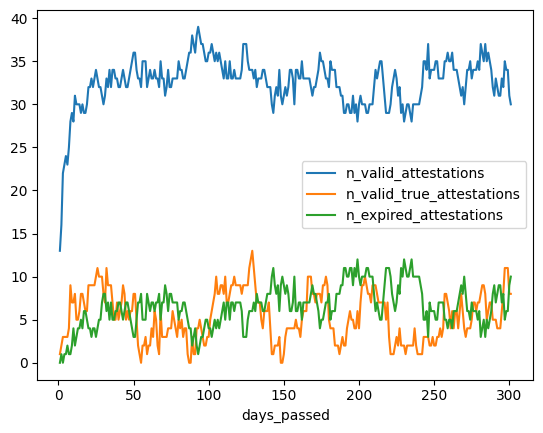

In [6]:
sim_results.plot(x='days_passed', y=['n_valid_attestations', 'n_valid_true_attestations', 'n_expired_attestations'])

<Axes: xlabel='days_passed'>

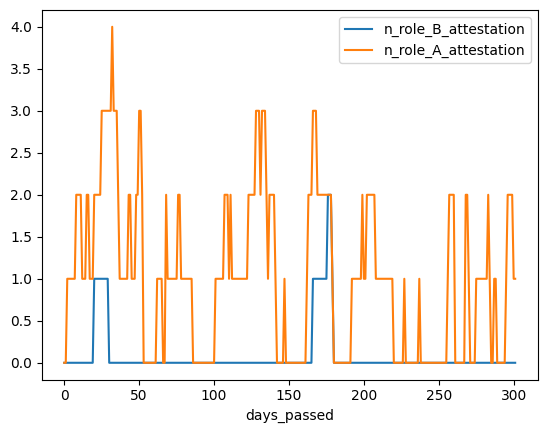

In [7]:
sim_df = sim_results.copy()
roles = set(el.attestation_uuid for el in params['role_certifactors'])
roles_cols = [f"n_{r}" for r in roles]
for col in roles_cols:
    sim_df[col] = 0.0
DEFAULT_RECORD = {f"n_{r}": 0.0 for r in roles}
n_roles_records = []

for (i, row) in sim_results.iterrows():
    t = row.days_passed
    agents = row.agents

    record = DEFAULT_RECORD.copy()
    for agent in agents:
        active_roles = {att.attestation_uuid for att in agent.sucessful_attestations(t)
                        if att.attestation_uuid in roles}
        for r in active_roles:
            record[f"n_{r}"] += 1

    for k, v in record.items():
        sim_df.loc[i, k] = v

sim_df.plot(x='days_passed', y=roles_cols)
